In [1]:
# import required packages
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# import MAGI-X packages
from scripts.magix.dynamic import nnSTModule, nnMTModule # neural network module
from scripts.magix.inference import FMAGI # inferred module

### FitzHugh-Nagumo

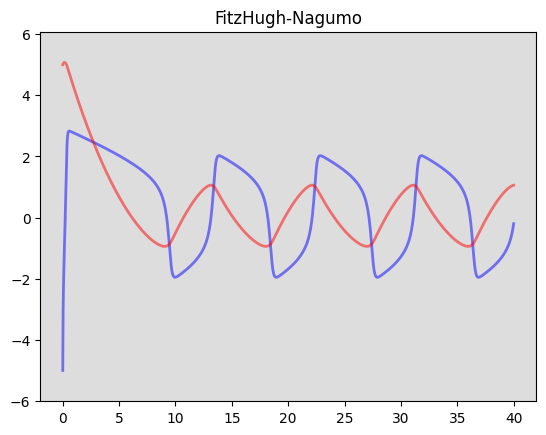

In [2]:
# define FitzHugh-Nagumo model dynamic
def FN(y, t, a, b, c):
	V, R = y
	dVdt = c * (V - np.power(V,3)/3.0 + R)
	dRdt = -1./c * (V - a + b*R)
	return (dVdt,dRdt)

# model parameters 
a, b, c = 0.2, 0.2, 3
# initial condition
V0 = -5
R0 = 5
y0 = V0, R0
# time point for evaluation
tdata = np.linspace(0, 40, 1281)
# integration
xdata = odeint(FN, y0, tdata, args = (a,b,c))
# visualization
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tdata, xdata[:,0], 'b', alpha=0.5, lw=2, label='V')
ax.plot(tdata, xdata[:,1], 'r', alpha=0.5, lw=2, label='R')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('FitzHugh-Nagumo')
plt.show()

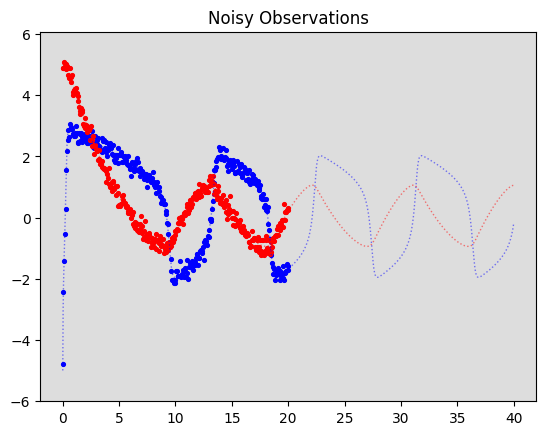

In [3]:
# setting
seed = 188714368 # random seed
noise = [0.15,0.15] # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [4]:
# MAP Inference - Multi-task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

/mnt/home/sykim/.conda/envs/py39/lib/python3.9/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1729647380992/work/torch/csrc/utils/tensor_new.cpp:651.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


1/1000 iteration: 27.450780
200/1000 iteration: 6.294664
400/1000 iteration: 3.825027
600/1000 iteration: 2.903458
800/1000 iteration: 2.445310
1000/1000 iteration: 2.179161
run time: 11.59 seconds


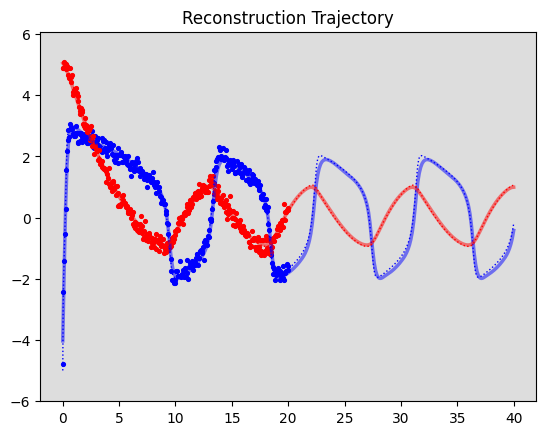

In [5]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [6]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 22.727906
200/1000 iteration: 4.804709
400/1000 iteration: 2.980801
600/1000 iteration: 2.363392
800/1000 iteration: 2.064043
1000/1000 iteration: 1.888615
run time: 12.63 seconds


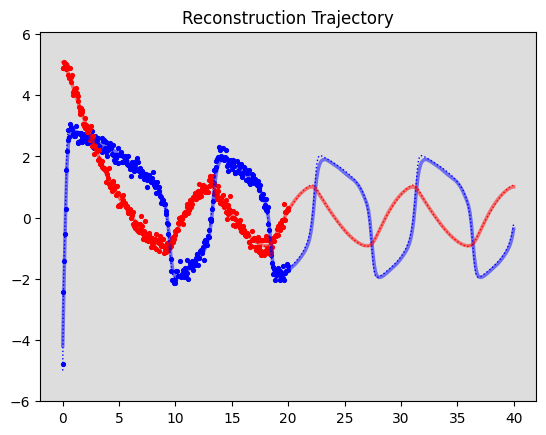

In [7]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [8]:
# Add vector field visualization functions
def compute_estimated_nullclines(model, resolution=100, x_range=(-2.5, 2.5), y_range=(-2.0, 2.0)):
    """Compute the estimated nullclines for a neural network model"""
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    
    for i in range(resolution):
        for j in range(resolution):
            state = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float64)
            with torch.no_grad():
                derivatives = model(state).numpy()
            U[i, j] = derivatives[0, 0]
            V[i, j] = derivatives[0, 1]
    
    return {'X': X, 'Y': Y, 'U': U, 'V': V}

def create_vector_field_plot(model, obs=None, title="Vector Field"):
    """Create a vector field plot for the FitzHugh-Nagumo model"""
    plt.figure(figsize=(10, 8))
    
    # Compute vector field
    grid_size = 20
    x = np.linspace(-2.5, 2.5, grid_size)
    y = np.linspace(-2.0, 2.0, grid_size)
    X, Y = np.meshgrid(x, y)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    
    for i in range(grid_size):
        for j in range(grid_size):
            state = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float64)
            with torch.no_grad():
                derivatives = model(state).numpy()
            U[i, j] = derivatives[0, 0]
            V[i, j] = derivatives[0, 1]
    
    magnitude = np.sqrt(U**2 + V**2)
    
    # Plot vector field
    q = plt.quiver(X, Y, U, V, magnitude, cmap=plt.cm.viridis, 
                 scale_units='xy', angles='xy', scale=25, width=0.004)
    plt.colorbar(q, label='Magnitude')
    
    # Calculate true nullclines
    nullcline_points = 1000
    x_null = np.linspace(-2.5, 2.5, nullcline_points)
    y_null1 = x_null**3 / 3 - x_null  # V-nullcline
    y_null2 = (0.2 - x_null) / 0.2     # R-nullcline
    
    # Plot true nullclines
    plt.plot(x_null, y_null1, 'r--', linewidth=1.5, alpha=0.7, label='True V-nullcline')
    plt.plot(x_null, y_null2, 'g--', linewidth=1.5, alpha=0.7, label='True R-nullcline')
    
    # Compute and plot estimated nullclines
    nullclines = compute_estimated_nullclines(model)
    plt.contour(nullclines['X'], nullclines['Y'], nullclines['U'], 
               levels=[0], colors=['r'], linewidths=2.0, linestyles='-', label='Est. V-nullcline')
    plt.contour(nullclines['X'], nullclines['Y'], nullclines['V'], 
               levels=[0], colors=['g'], linewidths=2.0, linestyles='-', label='Est. R-nullcline')
    
    # Plot observations if available
    if obs is not None:
        # Try to plot data points from observations
        try:
            # For FN model with 2 components
            v_obs = obs[0][:, 1].numpy() if isinstance(obs[0][:, 1], torch.Tensor) else obs[0][:, 1]
            r_obs = obs[1][:, 1].numpy() if isinstance(obs[1][:, 1], torch.Tensor) else obs[1][:, 1]
            plt.scatter(v_obs, r_obs, s=15, c='black', alpha=0.6, label='Observations')
        except:
            print("Could not plot observations")
    
    plt.title(title)
    plt.xlabel('V')
    plt.ylabel('R')
    plt.xlim([-2.5, 2.5])
    plt.ylim([-2.0, 2.0])
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Create comparison of vector fields between single and multiple starting points
def compare_vector_fields(model1, model2, obs1=None, obs2=None, title1="Single Starting Point", title2="Multiple Starting Points"):
    """Compare vector fields between two models"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot first model
    for i, (model, obs, title, ax) in enumerate(zip([model1, model2], [obs1, obs2], [title1, title2], axes)):
        # Compute vector field
        grid_size = 20
        x = np.linspace(-2.5, 2.5, grid_size)
        y = np.linspace(-2.0, 2.0, grid_size)
        X, Y = np.meshgrid(x, y)
        U = np.zeros_like(X)
        V = np.zeros_like(Y)
        
        for j in range(grid_size):
            for k in range(grid_size):
                state = torch.tensor([X[j, k], Y[j, k]], dtype=torch.float64)
                with torch.no_grad():
                    derivatives = model(state).numpy()
                U[j, k] = derivatives[0, 0]
                V[j, k] = derivatives[0, 1]
        
        magnitude = np.sqrt(U**2 + V**2)
        
        # Plot vector field
        q = ax.quiver(X, Y, U, V, magnitude, cmap=plt.cm.viridis, 
                     scale_units='xy', angles='xy', scale=25, width=0.004)
        if i == 1:  # Add colorbar only for the second plot
            plt.colorbar(q, ax=ax, label='Magnitude')
        
        # Calculate true nullclines
        nullcline_points = 1000
        x_null = np.linspace(-2.5, 2.5, nullcline_points)
        y_null1 = x_null**3 / 3 - x_null  # V-nullcline
        y_null2 = (0.2 - x_null) / 0.2     # R-nullcline
        
        # Plot true nullclines
        ax.plot(x_null, y_null1, 'r--', linewidth=1.0, alpha=0.7, label='True V-null')
        ax.plot(x_null, y_null2, 'g--', linewidth=1.0, alpha=0.7, label='True R-null')
        
        # Compute and plot estimated nullclines
        nullclines = compute_estimated_nullclines(model)
        ax.contour(nullclines['X'], nullclines['Y'], nullclines['U'], 
                  levels=[0], colors=['r'], linewidths=1.5, linestyles='-', label='Est V-null')
        ax.contour(nullclines['X'], nullclines['Y'], nullclines['V'], 
                  levels=[0], colors=['g'], linewidths=1.5, linestyles='-', label='Est R-null')
        
        # Plot observations if available
        if obs is not None:
            try:
                # For FN model with 2 components
                v_obs = obs[0][:, 1].numpy() if isinstance(obs[0][:, 1], torch.Tensor) else obs[0][:, 1]
                r_obs = obs[1][:, 1].numpy() if isinstance(obs[1][:, 1], torch.Tensor) else obs[1][:, 1]
                ax.scatter(v_obs, r_obs, s=10, c='black', alpha=0.6, label='Observations')
            except:
                pass
        
        ax.set_title(title)
        ax.set_xlabel('V')
        ax.set_ylabel('R')
        ax.set_xlim([-2.5, 2.5])
        ax.set_ylim([-2.0, 2.0])
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize='small')
    
    plt.tight_layout()
    plt.savefig("vector_field_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

/tmp/ipykernel_388593/2766167394.py:59: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(nullclines['X'], nullclines['Y'], nullclines['U'],
/tmp/ipykernel_388593/2766167394.py:61: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(nullclines['X'], nullclines['Y'], nullclines['V'],


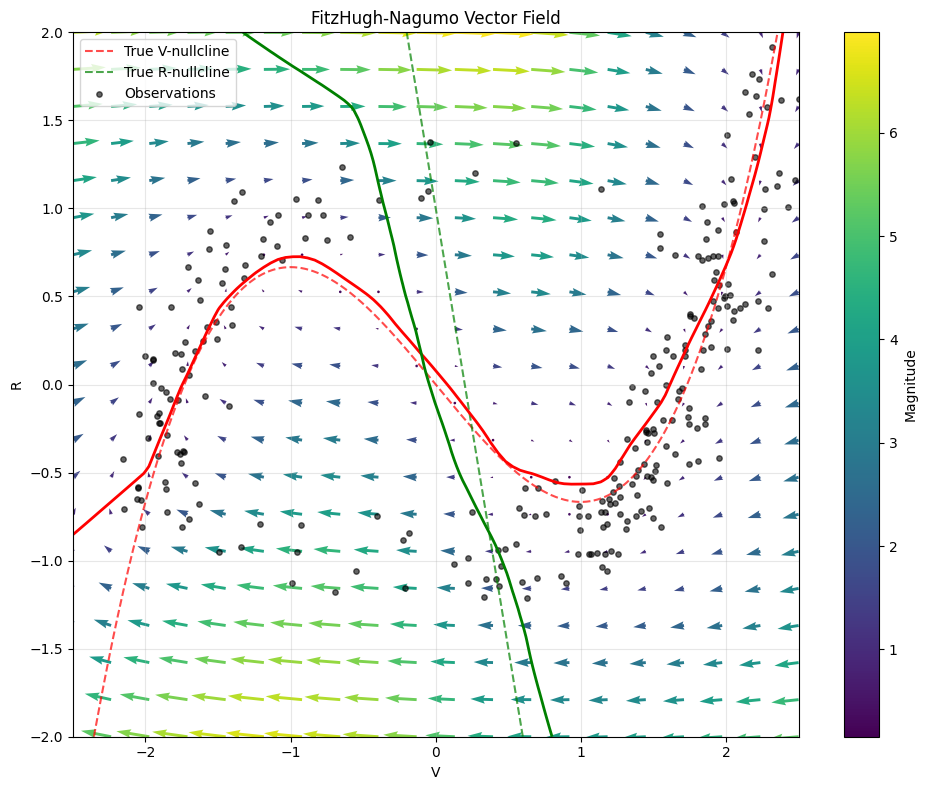

In [9]:
# Visualize the vector field for the FitzHugh-Nagumo model
create_vector_field_plot(fOde, obs=obs, title="FitzHugh-Nagumo Vector Field")

In [10]:
# Add functions for vector field visualization
def compute_true_vector_field(grid_size=20, x_range=(-2.5, 2.5), y_range=(-2.0, 2.0)):
    """Compute the true vector field for the FitzHugh-Nagumo model"""
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    for i in range(grid_size):
        for j in range(grid_size):
            d = FN([X[i, j], Y[i, j]], 0, a, b, c)
            U[i, j], V[i, j] = d[0], d[1]
    return {'X': X, 'Y': Y, 'U': U, 'V': V, 'magnitude': np.sqrt(U**2 + V**2)}

def compute_vector_field(model, grid_size=20, x_range=(-2.5, 2.5), y_range=(-2.0, 2.0)):
    """Compute the vector field for a neural network model"""
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    for i in range(grid_size):
        for j in range(grid_size):
            state = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float64)
            with torch.no_grad():
                d = model(state).numpy()
            U[i, j], V[i, j] = d[0, 0], d[0, 1]
    return {'X': X, 'Y': Y, 'U': U, 'V': V, 'magnitude': np.sqrt(U**2 + V**2)}

def compute_estimated_nullclines(model, resolution=200, x_range=(-2.5, 2.5), y_range=(-2.0, 2.0)):
    """Compute the estimated nullclines for a neural network model"""
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    for i in range(resolution):
        for j in range(resolution):
            state = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float64)
            with torch.no_grad():
                d = model(state).numpy()
            U[i, j], V[i, j] = d[0, 0], d[0, 1]
    return {'X': X, 'Y': Y, 'U': U, 'V': V}

def sample_training_data_for_visualization(states, max_points=1000):
    """Sample data points for visualization"""
    if states.shape[0] <= max_points:
        return states
    indices = np.linspace(0, states.shape[0]-1, max_points, dtype=int)
    return states[indices]

def plot_vector_field_comparison(true_vf, single_vf, multi_vf, single_model, multi_model, 
                                 single_states, multi_states, filename="vector_field_comparison.png"):
    """Create a three-panel comparison of vector fields"""
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Calculate true nullclines
    nullcline_points = 1000
    x_null = np.linspace(-2.5, 2.5, nullcline_points)
    y_null1 = x_null**3 / 3 - x_null  # V-nullcline
    y_null2 = (0.2 - x_null) / 0.2     # R-nullcline
    
    # Plot true vector field
    q0 = axes[0].quiver(true_vf['X'], true_vf['Y'], true_vf['U'], true_vf['V'], 
                       true_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q0, ax=axes[0], label='Magnitude')
    axes[0].plot(x_null, y_null1, 'r-', linewidth=1.5, label='V-nullcline')
    axes[0].plot(x_null, y_null2, 'g-', linewidth=1.5, label='R-nullcline')
    axes[0].set_title('True Vector Field')
    axes[0].legend(loc='upper right')
    
    # Plot single start vector field
    single_null = compute_estimated_nullclines(single_model)
    q1 = axes[1].quiver(single_vf['X'], single_vf['Y'], single_vf['U'], single_vf['V'], 
                       single_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q1, ax=axes[1], label='Magnitude')
    
    # Plot true nullclines with dashed lines for reference
    axes[1].plot(x_null, y_null1, 'r--', linewidth=1.0, alpha=0.5)
    axes[1].plot(x_null, y_null2, 'g--', linewidth=1.0, alpha=0.5)
    
    # Plot estimated nullclines
    axes[1].contour(single_null['X'], single_null['Y'], single_null['U'], 
                   levels=[0], colors=['r'], linewidths=1.5)
    axes[1].contour(single_null['X'], single_null['Y'], single_null['V'], 
                   levels=[0], colors=['g'], linewidths=1.5)
    
    # Plot training data points
    sampled_single = sample_training_data_for_visualization(single_states)
    axes[1].scatter(sampled_single[:, 0].numpy(), sampled_single[:, 1].numpy(), 
                   s=2.0, color='black', alpha=0.4)
    axes[1].set_title('Single Start Vector Field')
    
    # Plot multi start vector field
    multi_null = compute_estimated_nullclines(multi_model)
    q2 = axes[2].quiver(multi_vf['X'], multi_vf['Y'], multi_vf['U'], multi_vf['V'], 
                       multi_vf['magnitude'], cmap=plt.cm.viridis, 
                       scale_units='xy', angles='xy', scale=25, width=0.004)
    fig.colorbar(q2, ax=axes[2], label='Magnitude')
    
    # Plot true nullclines with dashed lines for reference
    axes[2].plot(x_null, y_null1, 'r--', linewidth=1.0, alpha=0.5)
    axes[2].plot(x_null, y_null2, 'g--', linewidth=1.0, alpha=0.5)
    
    # Plot estimated nullclines
    axes[2].contour(multi_null['X'], multi_null['Y'], multi_null['U'], 
                   levels=[0], colors=['r'], linewidths=1.5)
    axes[2].contour(multi_null['X'], multi_null['Y'], multi_null['V'], 
                   levels=[0], colors=['g'], linewidths=1.5)
    
    # Plot training data points
    sampled_multi = sample_training_data_for_visualization(multi_states)
    axes[2].scatter(sampled_multi[:, 0].numpy(), sampled_multi[:, 1].numpy(), 
                   s=2.0, color='black', alpha=0.4)
    axes[2].set_title('Multiple Start Vector Field')
    
    # Set common properties
    for ax in axes:
        ax.set_xlabel('V')
        ax.set_ylabel('R')
        ax.set_xlim([-2.5, 2.5])
        ax.set_ylim([-2.0, 2.0])
        ax.grid(True, alpha=0.3)
    
    # Set title
    fig.suptitle('Vector Field Comparison with Training Data and Estimated Nullclines', fontsize=16)
    
    # Save figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

Training single-start model...
Training multi-start model...


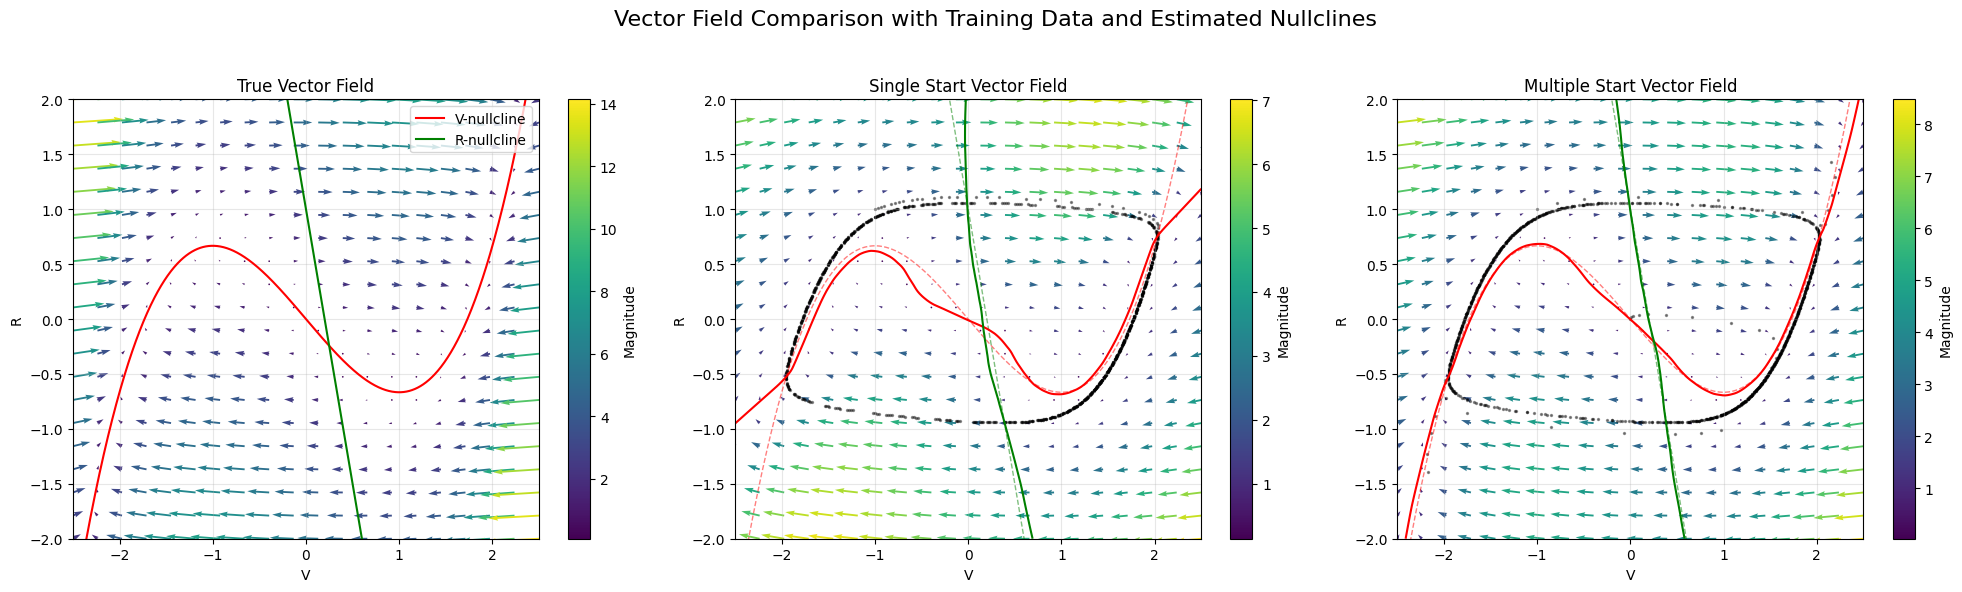

In [11]:
# IMPORTANT: Add this after you've trained your model fOde on the FN data

# Create and train a model with multiple starting points
single_start = [[-1.0, 1.0]]  # The original starting point
multi_start = [
    [-1.0, 1.0],   # Original starting point
    [1.0, -1.0],   # Opposite side
    [0.0, 0.0],    # Near equilibrium
    [2.0, 1.5],    # Right side
    [-2.0, -1.5]   # Left side
]

# Function to get states and derivatives from trajectories
def get_states_derivs(starting_points):
    """Generate trajectories and extract states and derivatives"""
    all_states, all_derivs = [], []
    
    for start_point in starting_points:
        # Generate trajectory from this starting point
        this_tdata = np.linspace(0, 40, 1281)
        this_xdata = odeint(FN, start_point, this_tdata, args=(a, b, c))
        
        # Convert to tensors
        states = torch.tensor(this_xdata, dtype=torch.float64)
        derivs = torch.tensor([FN(state, 0, a, b, c) for state in this_xdata], dtype=torch.float64)
        
        all_states.append(states)
        all_derivs.append(derivs)
    
    return torch.cat(all_states), torch.cat(all_derivs)

# Get single and multi-start data
single_states, single_derivs = get_states_derivs(single_start)
multi_states, multi_derivs = get_states_derivs(multi_start)

# Train neural network models directly on the trajectory data
def train_nn_model(states, derivs, hidden_size=512, epochs=1000):
    """Train a neural network model directly on state/derivative pairs"""
    no_comp = states.shape[1]
    model = nnMTModule(no_comp, [hidden_size], dp=0)
    
    # Standardize outputs
    deriv_means = torch.mean(derivs, dim=0)
    deriv_stds = torch.std(derivs, dim=0)
    model.update_output_layer(deriv_means, deriv_stds)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        pred_derivs = model(states)
        mse_loss = torch.mean((pred_derivs - derivs) ** 2)
        l2_reg = sum(p.pow(2.0).sum() for p in model.parameters())
        total_loss = mse_loss + 1e-4 * l2_reg
        total_loss.backward()
        optimizer.step()
    
    return model

# Train models on the single and multi-start data
print("Training single-start model...")
single_model = train_nn_model(single_states, single_derivs)

print("Training multi-start model...")
multi_model = train_nn_model(multi_states, multi_derivs)

# Compute vector fields
true_vf = compute_true_vector_field()
single_vf = compute_vector_field(single_model)
multi_vf = compute_vector_field(multi_model)

# Create visualization
plot_vector_field_comparison(
    true_vf, 
    single_vf, 
    multi_vf, 
    single_model, 
    multi_model, 
    single_states, 
    multi_states,
    filename="fn_vector_field_comparison.png"
)

In [12]:
import numpy as np
import torch
import time
from scipy.integrate import odeint
from scripts.magix.dynamic import nnSTModule, nnMTModule
from scripts.magix.inference_archive import FMAGI
import matplotlib.pyplot as plt
# 1. FitzHugh–Nagumo dynamics

# 1. FitzHugh–Nagumo dynamics
def FN(y, t, a, b, c):
    V, R = y
    dV = c * (V - V**3/3 + R)
    dR = -1.0/c * (V - a + b*R)
    return np.array([dV, dR])

# 2. Parameters & ground truth
a, b, c = 0.2, 0.2, 3.0
y0 = [-1.0, 1.0]
tdata = np.linspace(0, 40, 1281)
xtrue = odeint(FN, y0, tdata, args=(a, b, c))

# 3. Noisy single‐start observations
seed = 1234
np.random.seed(seed)
noise = [0.15, 0.15]
no_train = 321
idxs = np.linspace(0, (len(tdata)-1)//2, no_train).astype(int)
obs = []
for i in range(2):
    tt = tdata[idxs]
    yy = xtrue[idxs, i] + np.random.normal(0, noise[i], no_train)
    obs.append(np.column_stack((tt, yy)))

# 4. Single‐start MAGI-X inference
torch.manual_seed(seed)
fOde_st = nnSTModule(2, [512], dp=0)
magi_st  = FMAGI(obs, fOde_st, grid_size=161, interpolation_orders=3)

start = time.time()
_, x_st = magi_st.map(
    max_epoch=1000,
    learning_rate=1e-3,
    decay_learning_rate=False,
    hyperparams_update=False,
    dynamic_standardization=True,
    verbose=False,
    returnX=True
)
print("Single‐start MAGI-X time: %.1f s" % (time.time()-start))
single_net = magi_st.fOde  # trained NN: [V,R] -> [dV/dt, dR/dt]

# 5. Multi‐start observations: stack 5 trajectories
starts = [
    [-1.0,  1.0],
    [ 1.0, -1.0],
    [ 0.0,  0.0],
    [ 2.0,  1.5],
    [-2.0, -1.5],
]
p = 2
σ = noise
all_obs = [ [] for _ in range(p) ]
for y0i in starts:
    traj = odeint(FN, y0i, tdata, args=(a, b, c))
    for d in range(p):
        tt = tdata[idxs]
        yy = traj[idxs, d] + np.random.normal(0, σ[d], len(idxs))
        all_obs[d].append(np.column_stack((tt, yy)))
obs_mt = [ np.vstack(lst) for lst in all_obs ]

# 6. Multi‐start MAGI-X inference
torch.manual_seed(seed)
fOde_mt = nnMTModule(2, [512], dp=0)
magi_mt  = FMAGI(obs_mt, fOde_mt, grid_size=161, interpolation_orders=3)

start = time.time()
_, x_mt = magi_mt.map(
    max_epoch=1000,
    learning_rate=1e-3,
    decay_learning_rate=False,
    hyperparams_update=False,
    dynamic_standardization=True,
    verbose=False,
    returnX=True
)
print("Multi‐start MAGI-X time: %.1f s" % (time.time()-start))
multi_net = magi_mt.fOde

# 7. Compute vector fields
def compute_vf(model, bounds, n=20):
    vmin, vmax, rmin, rmax = bounds
    Vs = np.linspace(vmin, vmax, n)
    Rs = np.linspace(rmin, rmax, n)
    VV, RR = np.meshgrid(Vs, Rs, indexing='ij')
    dV = np.zeros_like(VV)
    dR = np.zeros_like(VV)
    for i in range(n):
        for j in range(n):
            z = torch.tensor([VV[i,j], RR[i,j]], dtype=torch.float64)
            with torch.no_grad():
                out = model(z).numpy().flatten()
            dV[i,j], dR[i,j] = out
    M = np.sqrt(dV**2 + dR**2)
    return VV, RR, dV, dR, M

bounds = (-2.5, 2.5, -2.0, 2.0)
true_vf   = compute_vf(lambda z: torch.tensor(FN(z.numpy(),0,a,b,c), dtype=torch.float64),
                      bounds)
single_vf = compute_vf(single_net, bounds)
multi_vf  = compute_vf(multi_net, bounds)

# 8. Plotting helper
def plot_vector_field_comparison(true_vf, single_vf, multi_vf,
                                 x_st, x_mt, bounds, filename=None):
    vmin, vmax, rmin, rmax = bounds
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    titles = ["True Vector Field", "MAGI-X Single", "MAGI-X Multi"]
    vfs = [true_vf, single_vf, multi_vf]
    data = [None, x_st, x_mt]

    for ax, title, vf, pts in zip(axes, titles, vfs, data):
        Vv, Rv, dV, dR, M = vf
        q = ax.quiver(Vv, Rv, dV, dR, M,
                      cmap="viridis", scale_units="xy", angles="xy",
                      scale=25, width=0.005)
        if pts is not None:
            pnts = pts if isinstance(pts, np.ndarray) else pts.numpy()
            ax.scatter(pnts[:,0], pnts[:,1], c="k", s=10, alpha=0.6)
        # nullclines
        xs = np.linspace(vmin, vmax, 300)
        ax.plot(xs, xs**3/3 - xs,  'r--', lw=2)
        ax.plot(xs, (xs - a)/b,    'g--', lw=2)
        ax.set_title(title, fontsize=14)
        ax.set_xlim(vmin, vmax)
        ax.set_ylim(rmin, rmax)
        ax.set_aspect('equal', 'box')
        ax.set_xlabel("V", fontsize=12)
    axes[0].set_ylabel("R", fontsize=12)
    # colorbar on first panel
    cb = fig.colorbar(q, ax=axes[0], shrink=0.8)
    cb.set_label("Magnitude", fontsize=12)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

# 9. Plot!
plot_vector_field_comparison(
    true_vf, single_vf, multi_vf,
    x_st, x_mt, bounds,
    filename="fn_vector_field_comparison.png"
)


/mnt/home/sykim/.conda/envs/py39/lib/python3.9/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():


Single‐start MAGI-X time: 20.1 s


KeyboardInterrupt: 

Single‐start MAGI-X time: 12.5 s
Multi‐start MAGI-X time: 13.2 s


/tmp/ipykernel_388593/3528922269.py:179: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(nc['X'], nc['Y'], nc['U'], levels=[0], colors='r', linestyles='--', lw=1.5)
/tmp/ipykernel_388593/3528922269.py:180: UserWarning: The following kwargs were not used by contour: 'lw'
  ax.contour(nc['X'], nc['Y'], nc['V'], levels=[0], colors='g', linestyles='--', lw=1.5)


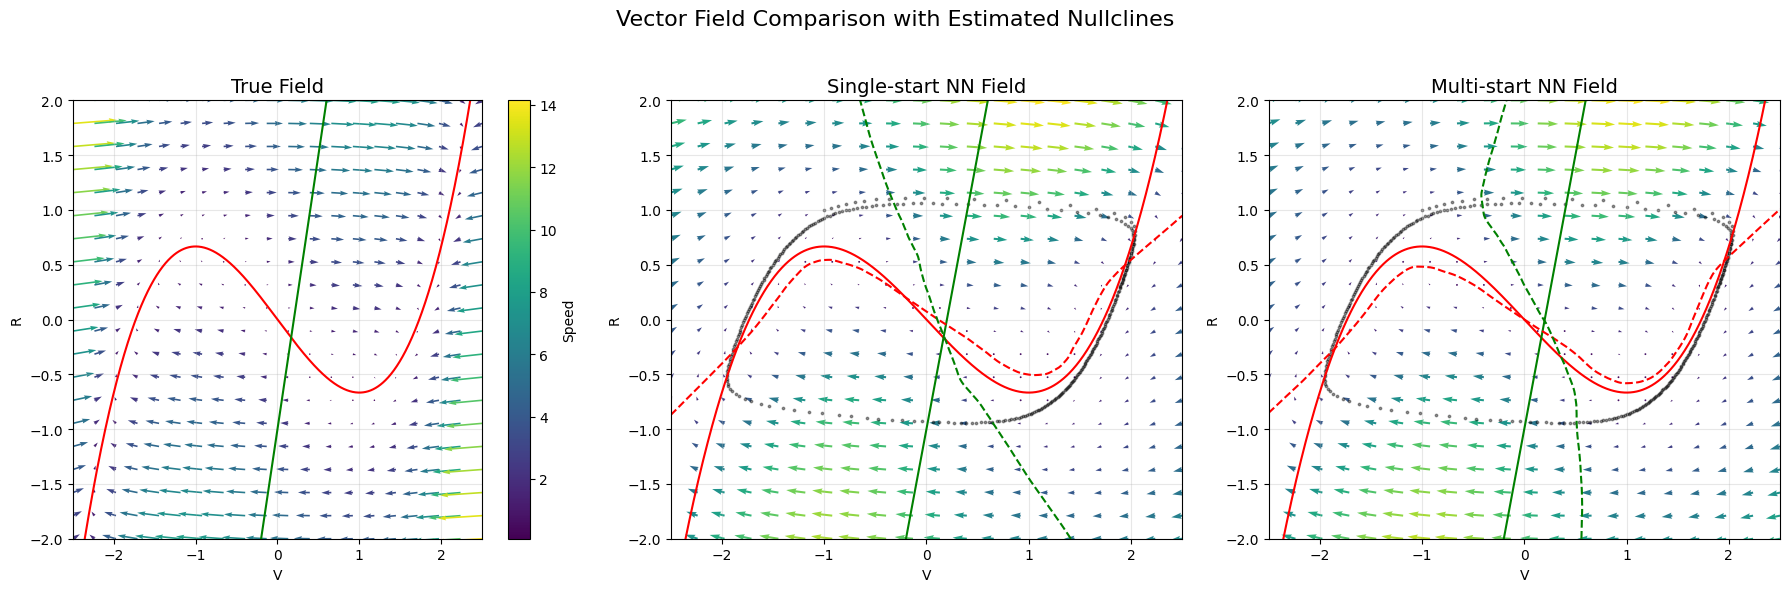

In [19]:
import numpy as np
import torch
import time
from scipy.integrate import odeint
from scripts.magix.dynamic import nnSTModule, nnMTModule
from scripts.magix.inference import FMAGI
import matplotlib.pyplot as plt

# 1. FitzHugh–Nagumo dynamics
def FN(y, t, a, b, c):
    V, R = y
    dV = c * (V - V**3/3 + R)
    dR = -1.0/c * (V - a + b*R)
    return np.array([dV, dR])

# 2. Parameters & ground truth
a, b, c = 0.2, 0.2, 3.0
y0 = [-1.0, 1.0]
tdata = np.linspace(0, 40, 1281)
xtrue = odeint(FN, y0, tdata, args=(a, b, c))

# 3. Noisy single‐start observations
seed = 1234
np.random.seed(seed)
noise = [0.15, 0.15]
no_train = 321
idxs = np.linspace(0, (len(tdata)-1)//2, no_train).astype(int)
obs = []
for i in range(2):
    tt = tdata[idxs]
    yy = xtrue[idxs, i] + np.random.normal(0, noise[i], no_train)
    obs.append(np.column_stack((tt, yy)))

# 4. Single‐start MAGI-X inference
torch.manual_seed(seed)
fOde_st = nnMTModule(2, [512])
magi_st = FMAGI(obs, fOde_st, grid_size=201, interpolation_orders=3)

start = time.time()
tinfer_st, xinfer_st = magi_st.map(
    max_epoch=2500,
    learning_rate=1e-3,
    decay_learning_rate=True,
    hyperparams_update=False,
    dynamic_standardization=True,
    verbose=False,
    returnX=True
)
print("Single‐start MAGI-X time: %.1f s" % (time.time()-start))
single_net = magi_st.fOde

# 5. Multi‐start observations: stack 5 trajectories
starts = [
    [-1.0,  1.0],
    # [ 1.0, -1.0],
    # [ 0.0,  0.0],
    # [ 2.0,  1.5],
    # [-2.0, -1.5],
]
p = 2
σ = noise
all_obs = [[] for _ in range(p)]
for y0i in starts:
    traj = odeint(FN, y0i, tdata, args=(a, b, c))
    for d in range(p):
        tt = tdata[idxs]
        yy = traj[idxs, d] + np.random.normal(0, σ[d], len(idxs))
        all_obs[d].append(np.column_stack((tt, yy)))
obs_mt = [np.vstack(lst) for lst in all_obs]

# 6. Multi‐start MAGI-X inference
torch.manual_seed(seed)
fOde_mt = nnMTModule(2, [512])
magi_mt = FMAGI(obs_mt, fOde_mt, grid_size=201, interpolation_orders=3)

start = time.time()
tinfer_mt, xinfer_mt = magi_mt.map(
    max_epoch=2500,
    learning_rate=1e-3,
    decay_learning_rate=True,
    hyperparams_update=False,
    dynamic_standardization=True,
    verbose=False,
    returnX=True
)
print("Multi‐start MAGI-X time: %.1f s" % (time.time()-start))
multi_net = magi_mt.fOde

# 7. Compute vector fields without any external bounds
def compute_true_vector_field(grid_size=20, x_range=(-2.5,2.5), y_range=(-2.0,2.0)):
    x = np.linspace(*x_range, grid_size)
    y = np.linspace(*y_range, grid_size)
    X, Y = np.meshgrid(x, y)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    for i in range(grid_size):
        for j in range(grid_size):
            dx = FN_true([X[i,j], Y[i,j]], 0)
            U[i,j], V[i,j] = dx
    return X, Y, U, V

def compute_vf(model, grid_size=20, x_range=(-2.5, 2.5), y_range=(-2.0, 2.0)):
    """Compute the vector field for a neural network model."""
    x = np.linspace(*x_range, grid_size)
    y = np.linspace(*y_range, grid_size)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    for i in range(grid_size):
        for j in range(grid_size):
            state = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float64)
            with torch.no_grad():
                d = model(state).numpy().flatten()
            U[i, j], V[i, j] = d[0], d[1]
    return {'X': X, 'Y': Y, 'U': U, 'V': V, 'M': np.sqrt(U**2 + V**2)}

def compute_nullclines(model, resolution=200, x_range=(-2.5, 2.5), y_range=(-2.0, 2.0)):
    """Compute estimated nullclines for a neural network model."""
    x = np.linspace(*x_range, resolution)
    y = np.linspace(*y_range, resolution)
    X, Y = np.meshgrid(x, y)
    U, V = np.zeros_like(X), np.zeros_like(Y)
    for i in range(resolution):
        for j in range(resolution):
            state = torch.tensor([X[i, j], Y[i, j]], dtype=torch.float64)
            with torch.no_grad():
                d = model(state).numpy().flatten()
            U[i, j], V[i, j] = d[0], d[1]
    return {'X': X, 'Y': Y, 'U': U, 'V': V}

true_vf   = compute_vf(lambda z: torch.tensor(FN(z.numpy(), 0, a, b, c), dtype=torch.float64))
single_vf = compute_vf(fOde_st)
multi_vf  = compute_vf(fOde_mt)

single_null = compute_nullclines(fOde_st)
multi_null  = compute_nullclines(fOde_mt)

# 8. Plotting helper that auto-extracts ranges from the true field
def plot_vector_field_comparison(true_vf, single_vf, multi_vf,
                                 single_null, multi_null,
                                 filename=None):
    # extract plotting limits from true_vf grid
    # X0, Y0 = true_vf['X'], true_vf['Y']
    # vmin, vmax = X0.min(), X0.max()
    # rmin, rmax = Y0.min(), Y0.max()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    titles = ["True Field", "Single-start NN Field", "Multi-start NN Field"]
    vfs = [true_vf, single_vf, multi_vf]
    nulls = [None, single_null, multi_null]

    # true nullcline formulas
    xs = np.linspace(-2.5, 2.5, 1000)
    y_null1 = xs**3/3 - xs
    y_null2 = (xs - a)/b

    # prepare trajectories
    single_traj = xtrue[idxs]
    multi_traj = np.vstack([
        odeint(FN, s, tdata, args=(a, b, c))[idxs]
        for s in starts
    ])

    for i, ax in enumerate(axes):
        vf = vfs[i]
        Q = ax.quiver(
            vf['X'], vf['Y'],
            vf['U'], vf['V'], vf['M'],
            cmap="viridis",
            scale_units="xy",
            angles="xy",
            scale=25,
            width=0.004
        )
        ax.plot(xs, y_null1, 'r-', lw=1.5, label='V-nullcline')
        ax.plot(xs, y_null2, 'g-', lw=1.5, label='R-nullcline')

        if i > 0:
            nc = nulls[i]
            ax.contour(nc['X'], nc['Y'], nc['U'], levels=[0], colors='r', linestyles='--', lw=1.5)
            ax.contour(nc['X'], nc['Y'], nc['V'], levels=[0], colors='g', linestyles='--', lw=1.5)
            traj = single_traj if i==1 else multi_traj
            if i==2 and len(traj) > 1000:
                traj = traj[np.random.choice(len(traj), 1000, replace=False)]
            ax.scatter(traj[:,0], traj[:,1], s=3, c='k', alpha=0.4)

        ax.set_title(titles[i], fontsize=14)
        ax.set_xlabel('V')
        ax.set_ylabel('R')
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-2, 2)
        ax.grid(True, alpha=0.3)
        if i==0:
            fig.colorbar(Q, ax=ax, label='Speed')

    fig.suptitle('Vector Field Comparison with Estimated Nullclines', fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.95])
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# 9. Plot!
plot_vector_field_comparison(
    true_vf, single_vf, multi_vf,
    single_null, multi_null,
    filename="fn_vector_field_comparison_no_bounds.png"
)


Before MAGI-X (single): -0.3792437507975037
After MAGI-X (single):  -0.36616571424309957
Before MAGI-X (multi): -0.3792437507975037
After MAGI-X (multi):  -0.3596196272919331


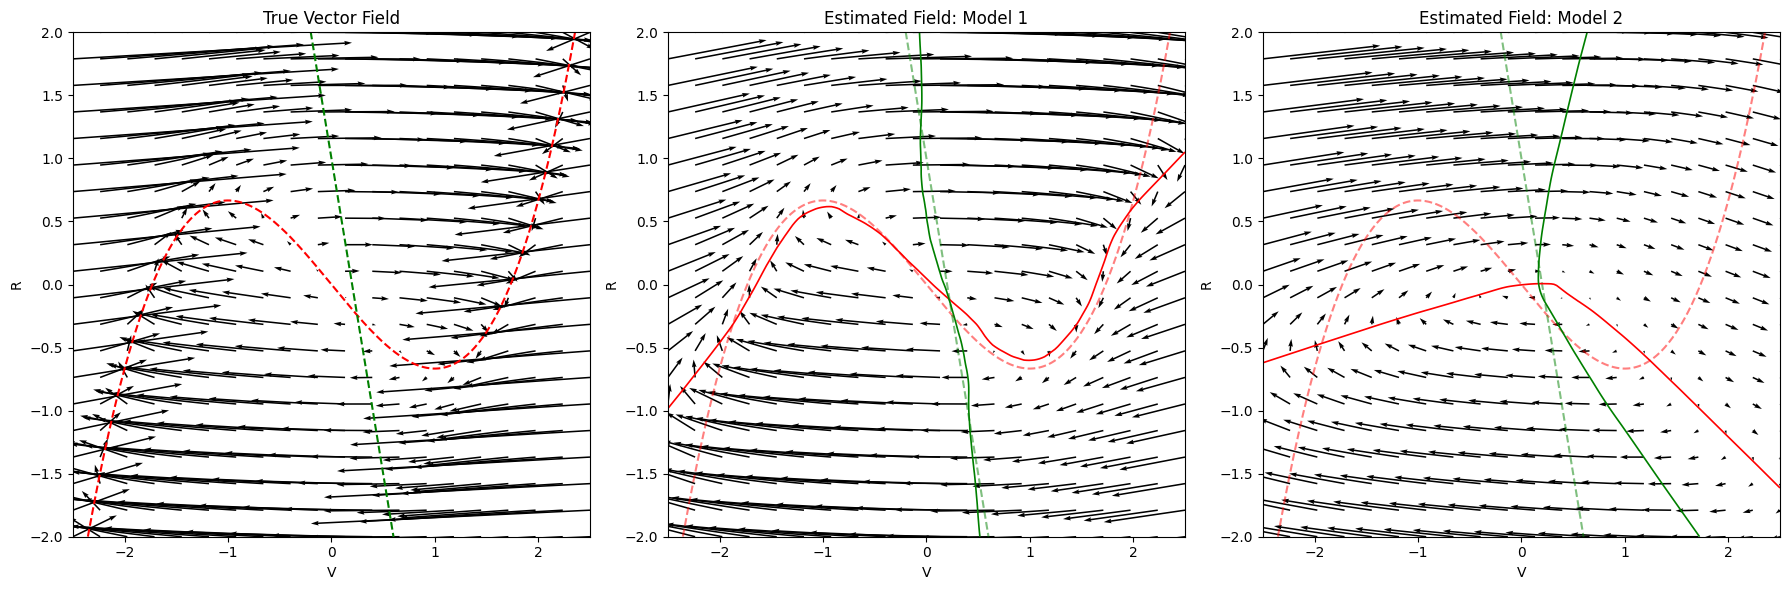

In [24]:
import numpy as np
import torch
import time
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scripts.magix.dynamic import nnSTModule, nnMTModule
from scripts.magix.inference import FMAGI

# 1. FitzHugh–Nagumo dynamics
def FN(y, t, a=0.2, b=0.2, c=3.0):
    V, R = y
    dV = c * (V - V**3/3 + R)
    dR = -1.0/c * (V - a + b * R)
    return np.array([dV, dR])

# 2. Parameters & ground truth
a, b, c = 0.2, 0.2, 3.0
y0_true = [-1.0, 1.0]

t_max = 40
n_points = 1281
noise_level = 0.1

t_grid = np.linspace(0, t_max, n_points)
x_clean = odeint(FN, [-1.0, 1.0], t_grid)
y_obs = np.column_stack((t_grid, x_clean))  # each row [t, V, R]

torch.set_default_dtype(torch.double)
# Build and run MAGI-X inference
# ys: list of tensors [n x 2] for each component: [time, value]
ys = []
for i in range(1, y_obs.shape[1]):
    data = torch.tensor(y_obs[:, [0, i]], dtype=torch.double)
    ys.append(data)

dim = 2
hidden_layers = [512]
starts = [
    [-1.0,  1.0],   # original single-start
    [ 1.0, -1.0],
    [ 0.0,  0.0],
    [ 2.0,  1.5],
    [-2.0, -1.5],
]
t_grid = np.linspace(0, t_max, n_points)

# build ys_mt: one big tensor per dimension
ys_mt = []
for d in range(2):                   # for V (d=0) and R (d=1)
    blocks = []
    for y0 in starts:
        traj = odeint(FN, y0, t_grid)            # simulate this start
        arr  = np.column_stack((t_grid, traj[:, d]))
        blocks.append(arr)
    big = np.vstack(blocks)                    # shape (5*1281, 2)
    ys_mt.append(torch.tensor(big, dtype=torch.double))



# 3. Single‐start noisy observations
# seed = 1234
# np.random.seed(seed)
noise = [0.00, 0.00]
no_train = 1281
# idxs = np.linspace(0,1281, no_train).astype(int)
idxs = np.arange(n_points)   
obs = []
for d in range(2):
    tt = tdata                 # full 0→40 grid
    # add Gaussian noise of std=noise[d]
    yy = xtrue[:, d] + np.random.normal(0, noise[d], size=no_train)
    arr = np.column_stack((tt, yy))
    # convert to torch tensor of shape (1281,2)
    obs.append(torch.tensor(arr, dtype=torch.double))
# for plotting
tt_single, yyV = obs[0][:,0], obs[0][:,1]
tt_single, yyR = obs[1][:,0], obs[1][:,1]

# 4. Single‐start MAGI-X inference
torch.manual_seed(seed)
fOde_st = nnMTModule(2, [512])
print("Before MAGI-X (single):", next(fOde_st.parameters())[0,0].item())

magi_st = FMAGI(ys, fOde_st, grid_size=201, interpolation_orders=3)
t0_st, x_st = magi_st.map(
    max_epoch=2500,
    learning_rate=1e-3,
    decay_learning_rate=True,
    hyperparams_update=False,
    dynamic_standardization=True,
    verbose=False,
    returnX=True
)
print("After MAGI-X (single): ", next(fOde_st.parameters())[0,0].item())

# 5. Multi‐start observations identical to before (for comparison)
starts = [[-1.0,1.0],[1.0,-1.0],[0.0,0.0],[2.0,1.5],[-2.0,-1.5]]
all_obs = [[] for _ in range(2)]
for y0i in starts:
    traj = odeint(FN, y0i, t_grid)
    for d in range(2):
        tt = t_grid[idxs]
        yy = traj[idxs, d] + np.random.normal(0, noise[d], len(idxs))
        all_obs[d].append(np.column_stack((tt, yy)))
obs_mt = [np.vstack(lst) for lst in all_obs]

torch.manual_seed(seed)
fOde_mt = nnMTModule(2, [512])
print("Before MAGI-X (multi):", next(fOde_mt.parameters())[0,0].item())

magi_mt = FMAGI(ys_mt, fOde_mt, grid_size=201, interpolation_orders=3)
t0_mt, x_mt = magi_mt.map(
    max_epoch=2500,
    learning_rate=1e-3,
    decay_learning_rate=True,
    hyperparams_update=False,
    dynamic_standardization=True,
    verbose=False,
    returnX=True
)
print("After MAGI-X (multi): ", next(fOde_mt.parameters())[0,0].item())

# 6. Evaluate vector fields and nullclines
def compute_true_vector_field(grid_size=20, x_range=(-2.5,2.5), y_range=(-2.0,2.0)):
    x = np.linspace(*x_range, grid_size)
    y = np.linspace(*y_range, grid_size)
    X, Y = np.meshgrid(x, y)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    for i in range(grid_size):
        for j in range(grid_size):
            dx = FN([X[i,j], Y[i,j]], 0)
            U[i,j], V[i,j] = dx
    return X, Y, U, V

def compute_estimated_vector_field(model, grid_size=20,
                                    x_range=(-2.5,2.5), y_range=(-2.0,2.0)):
    x = np.linspace(*x_range, grid_size)
    y = np.linspace(*y_range, grid_size)
    X, Y = np.meshgrid(x, y)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    for i in range(grid_size):
        for j in range(grid_size):
            inp = torch.tensor([X[i,j], Y[i,j]], dtype=torch.double)
            with torch.no_grad():
                dx = model(inp).numpy().ravel()
            U[i,j], V[i,j] = dx
    return X, Y, U, V

def compute_estimated_nullclines(model, resolution=200,
                                  x_range=(-2.5,2.5), y_range=(-2.0,2.0)):
    x = np.linspace(*x_range, resolution)
    y = np.linspace(*y_range, resolution)
    X, Y = np.meshgrid(x, y)
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    for i in range(resolution):
        for j in range(resolution):
            inp = torch.tensor([X[i,j], Y[i,j]], dtype=torch.double)
            with torch.no_grad():
                dx = model(inp).numpy().ravel()
            U[i,j], V[i,j] = dx
    return {'X': X, 'Y': Y, 'U': U, 'V': V}

# Analytical nullclines for FitzHugh–Nagumo
def true_nullclines(x_null):
    y_null1 = x_null**3 / 3 - x_null
    y_null2 = (0.2 - x_null) / 0.2
    return y_null1, y_null2


# compute fields
true_vf = compute_true_vector_field()
single_vf = compute_estimated_vector_field(fOde_st)
multi_vf  = compute_estimated_vector_field(fOde_mt)
single_nc = compute_estimated_nullclines(fOde_st)
multi_nc  = compute_estimated_nullclines(fOde_mt)

# 7. Plotting function

import numpy as np
import matplotlib.pyplot as plt

def plot_three_vector_fields(
    dynamic_model1,
    dynamic_model2,
    x_range=(-2.5, 2.5),
    y_range=(-2.0, 2.0),
    grid_size=20,
    nullcline_resolution=200,
    nullcline_points=400,
    true_cmap='viridis',
    est_cmap='plasma',
    true_scale=25,
    est_scale=25,
    figsize=(18, 6),
    filename=None
):
    """
    Plot three panels: true FN field, estimated by dynamic_model1, and estimated by dynamic_model2.

    Parameters
    ----------
    dynamic_model1, dynamic_model2 : torch.nn.Module
        Trained nnMTModule instances.
    x_range, y_range : tuple
        (min, max) for V and R axes.
    grid_size : int
        Number of arrows per axis for the quiver.
    nullcline_resolution : int
        Resolution for estimating nullclines from the models.
    nullcline_points : int
        Points for plotting analytical nullclines.
    true_cmap, est_cmap : str
        Colormaps for the quivers.
    true_scale, est_scale : float
        Scaling factors for arrow lengths.
    figsize : tuple
        Figure size.
    filename : str or None
        If given, save figure to this path at 300 dpi.
    """
    # 1) true field
    t_true = compute_true_vector_field(grid_size=grid_size,
                                       x_range=x_range,
                                       y_range=y_range)
    # 2) model 1 field
    t_est1 = compute_estimated_vector_field(dynamic_model1,
                                            grid_size=grid_size,
                                            x_range=x_range,
                                            y_range=y_range)
    nulls1 = compute_estimated_nullclines(dynamic_model1,
                                          resolution=nullcline_resolution,
                                          x_range=x_range,
                                          y_range=y_range)
    # 3) model 2 field
    t_est2 = compute_estimated_vector_field(dynamic_model2,
                                            grid_size=grid_size,
                                            x_range=x_range,
                                            y_range=y_range)
    nulls2 = compute_estimated_nullclines(dynamic_model2,
                                          resolution=nullcline_resolution,
                                          x_range=x_range,
                                          y_range=y_range)

    # analytical nullclines
    x_null = np.linspace(x_range[0], x_range[1], nullcline_points)
    y_null1, y_null2 = true_nullclines(x_null)

    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # --- panel 1: true ---
    X, Y, U, V = t_true
    axes[0].quiver(X, Y, U, V, cmap=true_cmap, scale=true_scale)
    axes[0].plot(x_null, y_null1, 'r--')
    axes[0].plot(x_null, y_null2, 'g--')
    axes[0].set_title('True Vector Field')
    axes[0].set_xlabel('V'); axes[0].set_ylabel('R')
    axes[0].set_xlim(x_range); axes[0].set_ylim(y_range)

    # --- panel 2: model1 ---
    X1, Y1, U1, V1 = t_est1
    axes[1].quiver(X1, Y1, U1, V1, cmap=est_cmap, scale=est_scale)
    axes[1].plot(x_null, y_null1, 'r--', alpha=0.5)
    axes[1].plot(x_null, y_null2, 'g--', alpha=0.5)
    axes[1].contour(nulls1['X'], nulls1['Y'], nulls1['U'],
                    levels=[0], colors=['r'], linewidths=1.2)
    axes[1].contour(nulls1['X'], nulls1['Y'], nulls1['V'],
                    levels=[0], colors=['g'], linewidths=1.2)
    axes[1].set_title('Estimated Field: Model 1')
    axes[1].set_xlabel('V'); axes[1].set_ylabel('R')
    axes[1].set_xlim(x_range); axes[1].set_ylim(y_range)

    # --- panel 3: model2 ---
    X2, Y2, U2, V2 = t_est2
    axes[2].quiver(X2, Y2, U2, V2, cmap=est_cmap, scale=est_scale)
    axes[2].plot(x_null, y_null1, 'r--', alpha=0.5)
    axes[2].plot(x_null, y_null2, 'g--', alpha=0.5)
    axes[2].contour(nulls2['X'], nulls2['Y'], nulls2['U'],
                    levels=[0], colors=['r'], linewidths=1.2)
    axes[2].contour(nulls2['X'], nulls2['Y'], nulls2['V'],
                    levels=[0], colors=['g'], linewidths=1.2)
    axes[2].set_title('Estimated Field: Model 2')
    axes[2].set_xlabel('V'); axes[2].set_ylabel('R')
    axes[2].set_xlim(x_range); axes[2].set_ylim(y_range)

    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=300)
    plt.show()

plot_three_vector_fields(fOde_st, fOde_mt, filename='comparison.png')









In [13]:
print(f"True VF - dV: {true_vf[2].min():.4f} to {true_vf[2].max():.4f}, dR: {true_vf[3].min():.4f} to {true_vf[3].max():.4f}")
print(f"Single VF - dV: {single_vf[2].min():.4f} to {single_vf[2].max():.4f}, dR: {single_vf[3].min():.4f} to {single_vf[3].max():.4f}")
print(f"Multi VF - dV: {multi_vf[2].min():.4f} to {multi_vf[2].max():.4f}, dR: {multi_vf[3].min():.4f} to {multi_vf[3].max():.4f}")

KeyError: 2

### Hes1

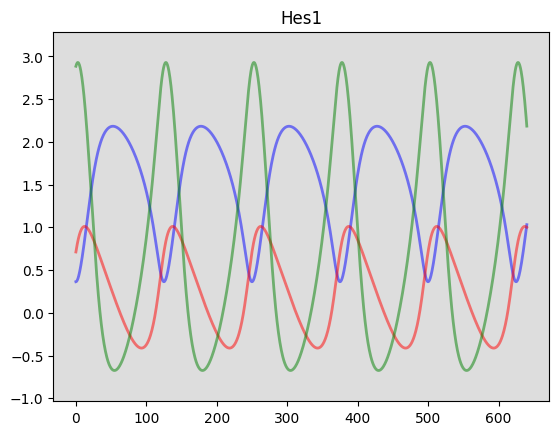

In [46]:
# define Hes1 model dynamic
def fOde(y, t, a, b, c, d, e, f, g):
	P, M, H = y
	dPdt = -a*P*H + b*M - c*P
	dMdt = -d*M + e/(1+np.power(P,2))
	dHdt = -a*P*H + f/(1+np.power(P,2)) - g*H
	return (dPdt,dMdt,dHdt)

# model parameters
a, b, c, d, e, f, g = 0.022, 0.3, 0.031, 0.028, 0.5, 20, 0.3
# initial condition
P0, M0, R0 = 1.438575, 2.037488, 17.90385
y0 = P0, M0, R0
# time point for evaluation
tdata = np.linspace(0, 640, 1281)
# integration 
xdata = odeint(fOde, y0, tdata, args = (a,b,c,d,e,f,g))
xdata = np.log(xdata)

fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tdata, xdata[:,0], 'b', alpha=0.5, lw=2, label='P')
ax.plot(tdata, xdata[:,1], 'r', alpha=0.5, lw=2, label='M')
ax.plot(tdata, xdata[:,2], 'g', alpha=0.5, lw=2, label='H')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Hes1')
plt.show()

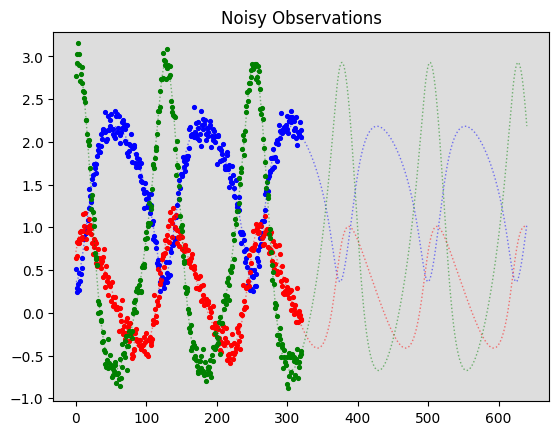

In [47]:
# setting
seed = 188714368 # random seed
noise = [0.10,0.10,0.10] # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [48]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class

from scripts.magix.inference_archive import FMAGI 
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=False,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=0, verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 10.348901
200/1000 iteration: 5.355932
400/1000 iteration: 4.250740
600/1000 iteration: 3.880906
800/1000 iteration: 3.737221
1000/1000 iteration: 3.670727
run time: 28.18 seconds


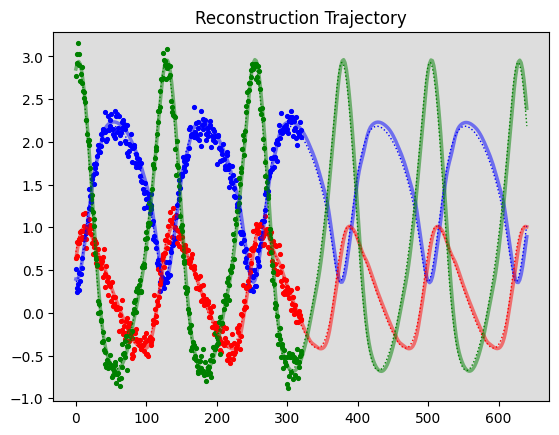

In [23]:
# reconstruction 
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [24]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=False,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=0, verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 10.154749
200/1000 iteration: 5.288609
400/1000 iteration: 4.224643
600/1000 iteration: 3.860401
800/1000 iteration: 3.720408
1000/1000 iteration: 3.654091
run time: 39.21 seconds


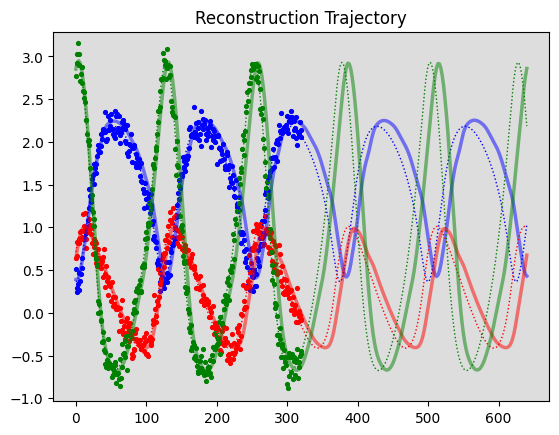

In [25]:
# reconstruction 
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [49]:
import numpy as np
import torch
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Define the true Hes1 dynamics function
def hes1_derivative(state, params):
    P, M, H = state
    a, b, c, d, e, f, g = params
    dP = -a * P * H + b * M - c * P
    dM = -d * M + e / (1 + P**2)
    dH = -a * P * H + f / (1 + P**2) - g * H
    return np.array([dP, dM, dH])

# 2. Compute a 3D vector field on a grid
def compute_vector_field_3d(model, grid_bounds, resolution=8):
    pmin, pmax, mmin, mmax, hmin, hmax = grid_bounds
    P = np.linspace(pmin, pmax, resolution)
    M = np.linspace(mmin, mmax, resolution)
    H = np.linspace(hmin, hmax, resolution)
    Pg, Mg, Hg = np.meshgrid(P, M, H, indexing='ij')
    U = np.zeros_like(Pg)
    V = np.zeros_like(Pg)
    W = np.zeros_like(Pg)
    for idx in np.ndindex(Pg.shape):
        inp = torch.tensor([Pg[idx], Mg[idx], Hg[idx]], dtype=torch.float64)
        with torch.no_grad():
            deriv = model(inp).numpy().flatten()
        U[idx], V[idx], W[idx] = deriv
    return Pg, Mg, Hg, U, V, W

# 3. Generate analytic nullcline surfaces
def analytic_nullclines(params, grid_bounds, resolution=50):
    a, b, c, d, e, f, g = params
    P = np.linspace(grid_bounds[0], grid_bounds[1], resolution)
    H = np.linspace(grid_bounds[4], grid_bounds[5], resolution)
    P2, H2 = np.meshgrid(P, H, indexing='ij')
    # P-nullcline: dP=0 => -a*P*H + b*M - c*P = 0 => M = (a*P*H + c*P)/b
    M_pnull = (a * P2 * H2 + c * P2) / b
    # M-nullcline: dM=0 => -d*M + e/(1+P^2) = 0 => M = e/(d*(1+P^2))
    M_mnull = e / (d * (1 + P2**2))
    # H-nullcline: dH=0 => -a*P*H + f/(1+P^2) - g*H = 0 => H*(a*P + g) = f/(1+P^2)
    H_hnull = f / ((1 + P2**2) * (a * P2 + g))
    return (P2, H2, M_pnull), (P2, H2, M_mnull), (P, np.zeros_like(P), np.zeros_like(P))  # simplified placeholder

# 4. Plot comparison using Plotly
def plot_3d_comparison(true_vf, single_vf, multi_vf, single_pts, multi_pts, grid_bounds):
    fig = make_subplots(rows=1, cols=3,
                        specs=[[{'type': 'scene'}, {'type': 'scene'}, {'type': 'scene'}]],
                        subplot_titles=("True Vector Field", "Single-Start Estimate", "Multi-Start Estimate"))
    
    # Helper to add traces
    def add_traces(scene, vf, pts, include_true=False):
        Pg, Mg, Hg, U, V, W = vf
        fig.add_trace(go.Cone(x=Pg.flatten(), y=Mg.flatten(), z=Hg.flatten(),
                              u=U.flatten(), v=V.flatten(), w=W.flatten(),
                              sizemode='absolute', sizeref=2, anchor='tail',
                              showscale=False), row=1, col=scene)
        if pts is not None:
            fig.add_trace(go.Scatter3d(x=pts[:,0], y=pts[:,1], z=pts[:,2],
                                       mode='markers', marker=dict(size=3, color='black'),
                                       name='Training Data'), row=1, col=scene)
        if include_true:
            # Analytic nullclines as surfaces
            pnull, mnull, hnull = analytic_nullclines(params, grid_bounds)
            P2, H2, M_p = pnull
            fig.add_trace(go.Surface(x=P2, y=M_p, z=H2, opacity=0.5, colorscale='Reds', showscale=False, name='P-null'), row=1, col=scene)
            fig.add_trace(go.Surface(x=P2, y=M_p, z=H2, opacity=0.5, colorscale='Greens', showscale=False, name='M-null'), row=1, col=scene)
    
    params = (0.022, 0.3, 0.031, 0.028, 0.5, 20.0, 0.3)
    
    add_traces(1, true_vf, None, include_true=True)
    add_traces(2, single_vf, single_pts)
    add_traces(3, multi_vf, multi_pts)
    
    # Update layout
    for i in range(1,4):
        fig['layout'][f'scene{i}'].update(xaxis_title='P', yaxis_title='M', zaxis_title='H',
                                         xaxis=dict(range=[grid_bounds[0], grid_bounds[1]]),
                                         yaxis=dict(range=[grid_bounds[2], grid_bounds[3]]),
                                         zaxis=dict(range=[grid_bounds[4], grid_bounds[5]]))
    fig.update_layout(height=600, width=1800, title_text="3D Vector Field Comparison for Hes1")
    fig.show()

# Usage example:
# Assuming `single_model` and `multi_model` are trained torch models,
# and `single_states`, `multi_states` are your training data tensors of shape (N,3).

# Define grid bounds for P, M, H
# grid_bounds = (-1.0, 3.0, 0.0, 4.0, 0.0, 20.0)

# # Compute vector fields
# true_vf = compute_vector_field_3d(lambda x: torch.tensor(hes1_derivative(x.numpy(), params)), grid_bounds)
# single_vf = compute_vector_field_3d(single_model, grid_bounds)
# multi_vf  = compute_vector_field_3d(multi_model, grid_bounds)

# # Convert training data to numpy
# single_pts = single_states.numpy()
# multi_pts  = multi_states.numpy()

# # Plot the comparison
# plot_3d_comparison(true_vf, single_vf, multi_vf, single_pts, multi_pts, grid_bounds)


In [51]:
import numpy as np
import torch
from scipy.integrate import odeint
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- 1. Define the true Hes1 derivative (for building the "true" field) ---
def hes1_derivative(y, params):
    P, M, H = y
    a, b, c, d, e, f, g = params
    dP = -a * P * H + b * M - c * P
    dM = -d * M + e / (1 + P**2)
    dH = -a * P * H + f / (1 + P**2) - g * H
    return np.array([dP, dM, dH])

# pack the parameters
params = (0.022, 0.3, 0.031, 0.028, 0.5, 20.0, 0.3)

# True‐model wrapper for compute_vector_field_3d
true_model = lambda x: torch.from_numpy(hes1_derivative(x.numpy(), params)).double()

# --- 2. Vector‐field grid generator ---
def compute_vector_field_3d(model, grid_bounds, resolution=8):
    pmin, pmax, mmin, mmax, hmin, hmax = grid_bounds
    P = np.linspace(pmin, pmax, resolution)
    M = np.linspace(mmin, mmax, resolution)
    H = np.linspace(hmin, hmax, resolution)
    Pg, Mg, Hg = np.meshgrid(P, M, H, indexing='ij')
    U = np.zeros_like(Pg); V = np.zeros_like(Pg); W = np.zeros_like(Pg)
    for idx in np.ndindex(Pg.shape):
        inp = torch.tensor([Pg[idx], Mg[idx], Hg[idx]], dtype=torch.float64)
        with torch.no_grad():
            deriv = model(inp).numpy().flatten()
        U[idx], V[idx], W[idx] = deriv
    return Pg, Mg, Hg, U, V, W

# --- 3. Analytic nullclines surfaces (P vs H vs M) ---
def analytic_nullclines(params, grid_bounds, resolution=50):
    a, b, c, d, e, f, g = params
    pmin, pmax, _, _, hmin, hmax = grid_bounds
    P = np.linspace(pmin, pmax, resolution)
    H = np.linspace(hmin, hmax, resolution)
    P2, H2 = np.meshgrid(P, H, indexing='ij')
    # V‐nullcline: dP=0 => M = (a*P*H + c*P)/b
    M_pnull = (a * P2 * H2 + c * P2) / b
    # M‐nullcline: dM=0 => M = e/(d*(1+P^2))
    M_mnull = e / (d * (1 + P2**2))
    return (P2, H2, M_pnull), (P2, H2, M_mnull)

# --- 4. Plotly 3‐panel comparison ---
def plot_3d_comparison(true_vf, single_vf, multi_vf, train_pts, grid_bounds):
    fig = make_subplots(rows=1, cols=3,
                        specs=[[{'type': 'scene'}]*3],
                        subplot_titles=("True Field", "Single‐Start", "Multi‐Start"))
    def add_field(col, vf, include_null=False):
        Pg, Mg, Hg, U, V, W = vf
        fig.add_trace(go.Cone(x=Pg.flatten(), y=Mg.flatten(), z=Hg.flatten(),
                              u=U.flatten(), v=V.flatten(), w=W.flatten(),
                              sizemode='absolute', sizeref=2, anchor='tail',
                              showscale=(col==3)),
                      row=1, col=col)
        fig.add_trace(go.Scatter3d(x=train_pts[:,0], y=train_pts[:,1], z=train_pts[:,2],
                                   mode='markers', marker=dict(size=3, color='black'),
                                   name='Data'), row=1, col=col)
        if include_null:
            pnull, mnull = analytic_nullclines(params, grid_bounds)
            P2, H2, M_p = pnull
            _, _, M_m = mnull
            fig.add_trace(go.Surface(x=P2, y=M_p, z=H2,
                                     opacity=0.4, colorscale='Reds', showscale=False),
                          row=1, col=col)
            fig.add_trace(go.Surface(x=P2, y=M_m, z=H2,
                                     opacity=0.4, colorscale='Greens', showscale=False),
                          row=1, col=col)

    add_field(1, true_vf,  include_null=True)
    add_field(2, single_vf, include_null=False)
    add_field(3, multi_vf,  include_null=False)

    for i in range(1,4):
        fig.update_layout({f'scene{i}': dict(
            xaxis=dict(title='P', range=grid_bounds[0:2]),
            yaxis=dict(title='M', range=grid_bounds[2:4]),
            zaxis=dict(title='H', range=grid_bounds[4:6]),
        )})
    fig.update_layout(height=600, width=1800,
                      title_text="3D Hes1 Vector Field Comparison")
    fig.show()

# --- 5. Extract your trained nets from FMAGI objects ---
# After your two FMAGI runs, do:
#   multi_model = <first FMAGI(...)>
#   single_model = <second FMAGI(...)>
multi_net  = multi_model.fOde
single_net = single_model.fOde

# --- 6. Build the training‐data cloud for scatter in 3D phase‐space ---
# `obs` is your list of [time, value] arrays for P, M, H; same time‐indices
train_pts = np.column_stack([obs[i][:,1] for i in range(len(obs))])

# --- 7. Compute all three vector‐fields on a shared grid ---
grid_bounds = (-1.0, 3.0,  0.0, 4.0,  0.0, 20.0)
true_vf   = compute_vector_field_3d(true_model,  grid_bounds, resolution=8)
single_vf = compute_vector_field_3d(single_net,   grid_bounds, resolution=8)
multi_vf  = compute_vector_field_3d(multi_net,    grid_bounds, resolution=8)

# --- 8. Fire up the Plotly comparison ---
plot_3d_comparison(true_vf, single_vf, multi_vf, train_pts, grid_bounds)


AttributeError: 'nnMTModule' object has no attribute 'fOde'

In [34]:
# MAP inference on Hes1
fOde = nnMTModule(no_comp, [512], dp=0)
model_hes1 = FMAGI(obs, fOde, grid_size=161, interpolation_orders=3)
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=False,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=0, verbose=True, returnX=True)


1/1000 iteration: 9.217564
200/1000 iteration: 4.880431
400/1000 iteration: 4.003313
600/1000 iteration: 3.716059
800/1000 iteration: 3.604264
1000/1000 iteration: 3.551247


In [35]:
single_hes1_net = model_hes1.fOde    # that’s your 3-input network


In [30]:
# 0. define your Hes1 parameters once
params = (0.022, 0.3, 0.031, 0.028, 0.5, 20.0, 0.3)

# 1. Compute the *true* vector field by wrapping your analytic derivative in a "model" callable
true_model = lambda x: torch.from_numpy(
    hes1_derivative(x.numpy(), params)
).double()

# 2. Now compute the three fields
grid_bounds = (-1.0, 3.0,   # P min/max
               0.0, 4.0,   # M min/max
               0.0, 20.0)  # H min/max

true_vf   = compute_vector_field_3d(true_model,  grid_bounds, resolution=8)
single_vf = compute_vector_field_3d(single_model, grid_bounds, resolution=8)
multi_vf  = compute_vector_field_3d(multi_model,  grid_bounds, resolution=8)

# 3. Convert your training trajectories to numpy
single_pts = single_states.numpy()
multi_pts  = multi_states.numpy()

# 4. Finally, plot
plot_3d_comparison(true_vf, single_vf, multi_vf,
                   single_pts, multi_pts,
                   grid_bounds)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x3 and 2x512)

### Loren 96

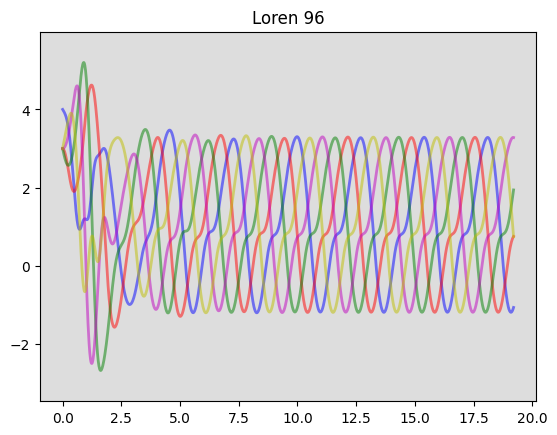

In [92]:
def L96(y, t, F):
    """Lorenz 96 model with constant forcing"""
    N = y.size
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (y[(i + 1) % N] - y[i - 2]) * y[i - 1] - y[i] + F
    return d

# model parameters
F = 3
# initial conditions
y0 = F * np.ones(5)  # Initial state (equilibrium)
y0[0] += 1.0  # Add small perturbation to the first variable
# time point for evaluation
tdata = np.linspace(0.0, 19.2, 1281)
# integration 
xdata = odeint(L96, y0, tdata, args=(F,))

# visualize the groundtruth trajectory
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(xdata.shape[1]):
    ax.plot(tdata, xdata[:,i], color=col[i], alpha=0.5, lw=2)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Loren 96')
plt.show()

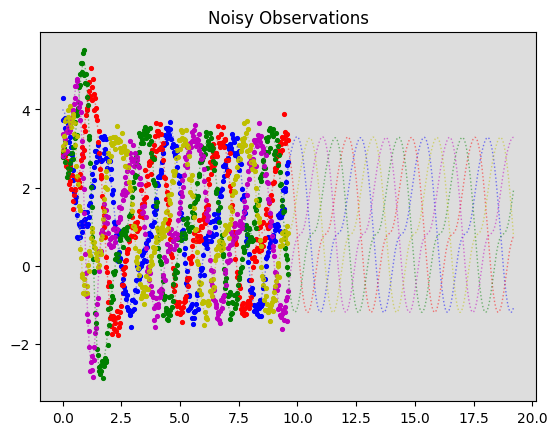

In [93]:
# setting
seed = 188714368 # random seed
noise = [0.2] * xdata.shape[1] # noise level
no_train = 321 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [94]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0.0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=0, verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 42.481572
200/1000 iteration: 12.836390
400/1000 iteration: 8.454057
600/1000 iteration: 7.042123
800/1000 iteration: 6.477923
1000/1000 iteration: 6.224532
run time: 62.60 seconds


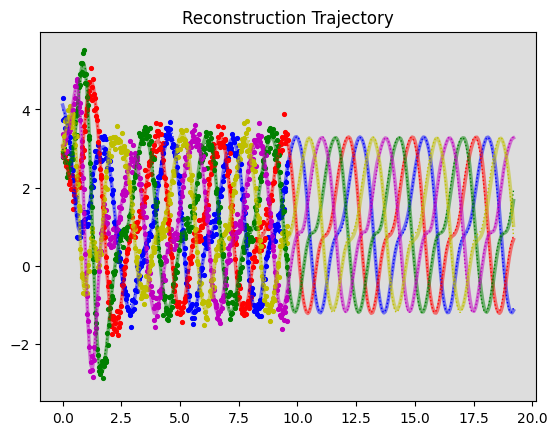

In [95]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

In [81]:
# MAP Inference - Multi Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnMTModule(no_comp, [512], dp=0.0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=0, verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 58.496724
200/1000 iteration: 16.048428
400/1000 iteration: 9.702938
600/1000 iteration: 7.649024
800/1000 iteration: 6.817555
1000/1000 iteration: 6.430939
run time: 41.60 seconds


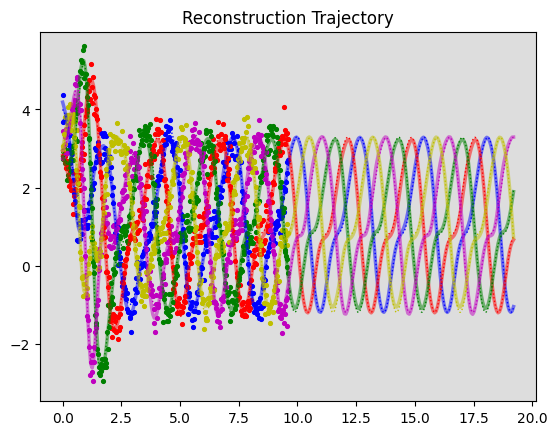

In [82]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

### Loren 96 Chaotic

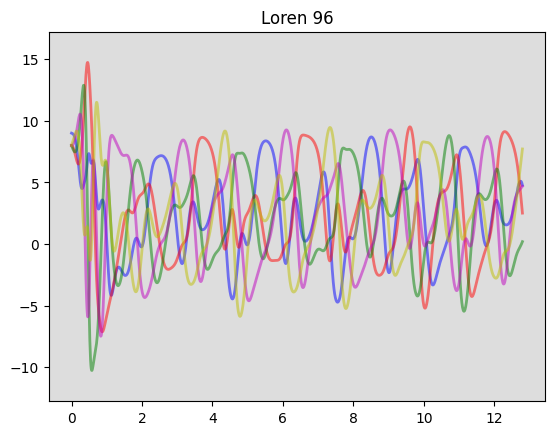

In [47]:
def L96(y, t, F):
    """Lorenz 96 model with constant forcing"""
    N = y.size
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (y[(i + 1) % N] - y[i - 2]) * y[i - 1] - y[i] + F
    return d

# model parameters
F = 8
# initial conditions
y0 = F * np.ones(5)  # Initial state (equilibrium)
y0[0] += 1.0  # Add small perturbation to the first variable
# time point for evaluation
tdata = np.linspace(0.0, 12.8, 1281)
# integration 
xdata = odeint(L96, y0, tdata, args=(F,))

# visualize the groundtruth trajectory
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(xdata.shape[1]):
    ax.plot(tdata, xdata[:,i], color=col[i], alpha=0.5, lw=2)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Loren 96')
plt.show()

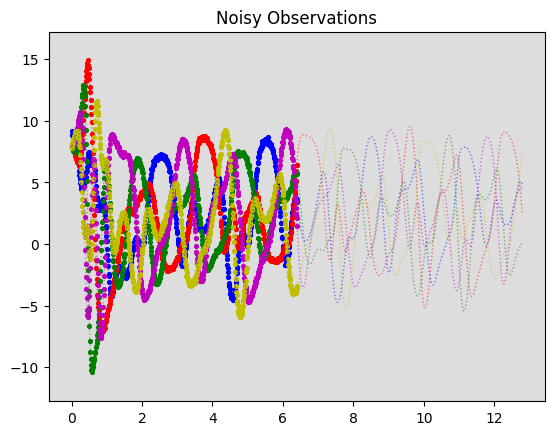

In [48]:
# setting
seed = 188714368 # random seed
noise = [0.10] * 5 # noise level
no_train = 641 # number of training samples 41/81/161/321/641/1281

# observation
obs = []
no_comp = xdata.shape[1] # number of components
obs_idx = np.linspace(0,int((tdata.size-1)/2),no_train).astype(int)
np.random.seed(seed) # set random seed for noise
for i in range(no_comp):
    tobs = tdata[obs_idx].copy()
    yobs = xdata[obs_idx,i].copy() + np.random.normal(0,noise[i],no_train)
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))
    
# visualize the groundtruth trajectory and the noisy data
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tdata, xdata[:,i], color=col[i], linestyle=':', alpha=0.5, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Noisy Observations')
plt.show()

In [49]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=161,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    kappa=0, verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 18.281010
200/1000 iteration: 14.257597
400/1000 iteration: 13.599428
600/1000 iteration: 13.268598
800/1000 iteration: 13.052236
1000/1000 iteration: 12.889098
run time: 75.56 seconds


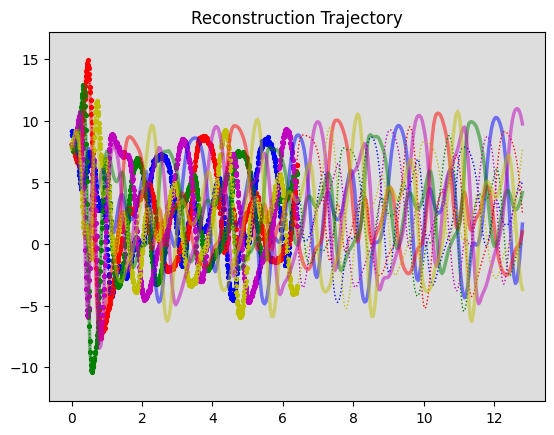

In [50]:
# reconstruction with ode numerical integration
trecon = tdata[np.linspace(0,tdata.size-1,321).astype(int)]
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
for i in range(no_comp):
    ax.plot(tr, xr[:,i], color=col[i], alpha=0.5, lw=2.5)
    ax.plot(tdata, xdata[:,i], linestyle=':', color=col[i], alpha=1, lw=1)
    ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata),np.max(xdata)+0.1*np.ptp(xdata))
plt.title('Reconstruction Trajectory')
plt.show()

### Climate Data

In [51]:
climate = pd.read_csv("data/DailyDelhiClimate.csv")
climate.head(5)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [52]:
# preprocess data
tmax = 1000 # consider only first 1000 data points for now
tdata = climate.index.to_numpy()[:tmax] # time
xdata = climate.iloc[:tmax,1:].to_numpy() # component values
xdata = np.log(xdata + 1e-3) # train it in log
xdata = (xdata - np.mean(xdata, axis=0))/np.std(xdata, axis=0) # standardization

# observation
tmax_train = 500
no_comp = xdata.shape[1] # number of components
obs = [] # set random seed for noise
for i in range(no_comp):
    tobs = tdata[:tmax_train].copy()
    yobs = xdata[:tmax_train,i].copy()
    obs.append(np.hstack((tobs.reshape(-1,1),yobs.reshape(-1,1))))

In [58]:
# MAP Inference - Single Task Neural Network
torch.manual_seed(seed)
# define neural network dynamic
fOde = nnSTModule(no_comp, [512], dp=0) # dp for dropout probability
# time recording
start_time = time.time()
# call inference class
model = FMAGI(obs,fOde,grid_size=251,interpolation_orders=3) 
# map inference
tinfer, xinfer = model.map(max_epoch=1000,
                    learning_rate=1e-3, decay_learning_rate=True,
                    hyperparams_update=False, dynamic_standardization=True,
                    verbose=True, returnX=True)
end_time = time.time()
run_time = end_time - start_time
print("run time: %.2f seconds" %(run_time))

1/1000 iteration: 17.869349
200/1000 iteration: 9.893996
400/1000 iteration: 7.764493
600/1000 iteration: 6.928090
800/1000 iteration: 6.539244
1000/1000 iteration: 6.332493
run time: 53.55 seconds


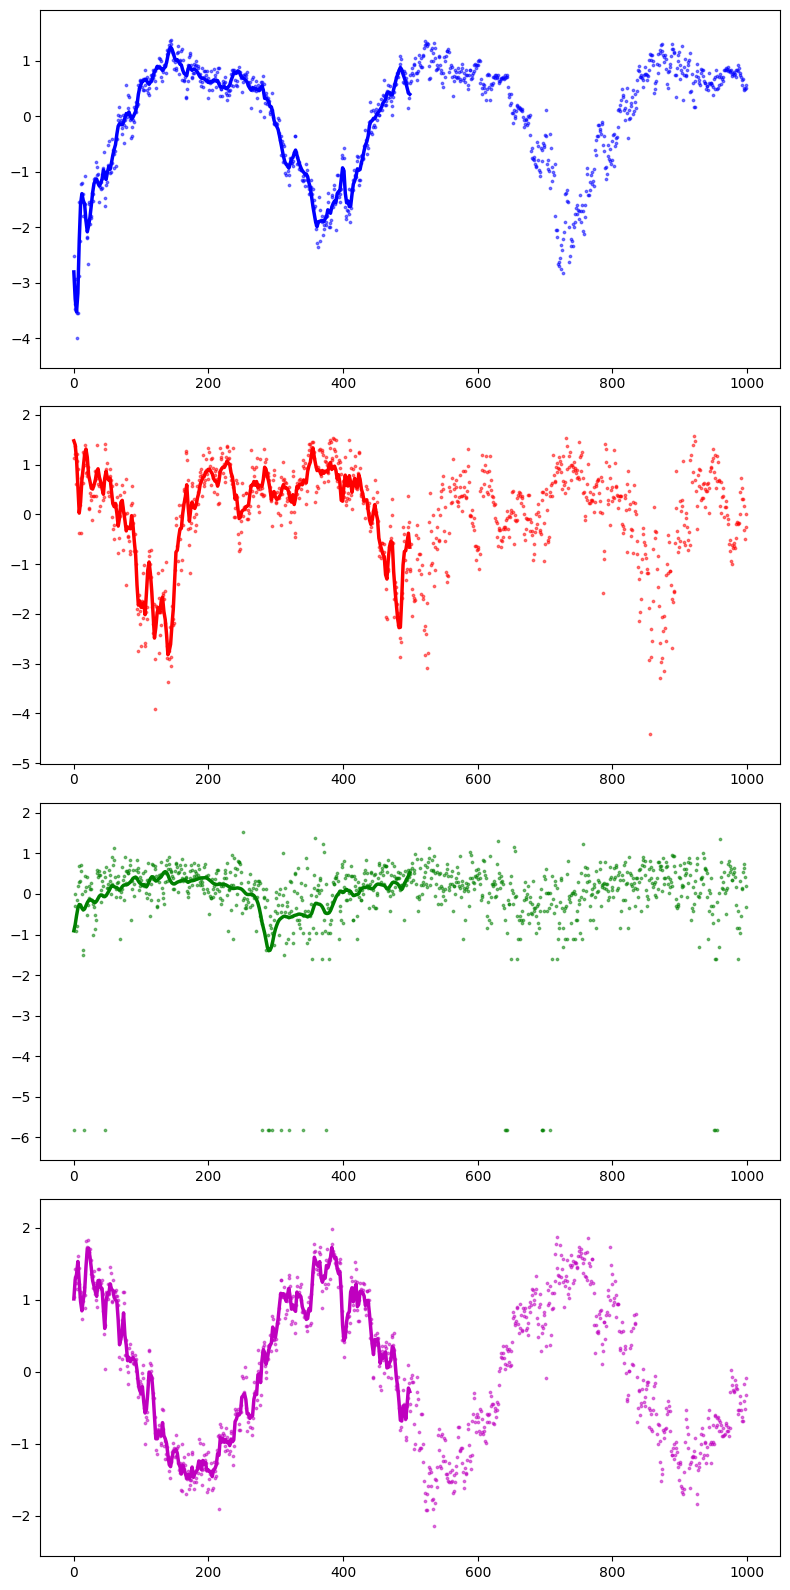

In [59]:
# inferred 
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(figsize=(8,16), facecolor='w')
for i in range(no_comp):
    ax = fig.add_subplot(no_comp, 1, (i+1))
    ax.plot(tinfer, xinfer[:,i], color=col[i], lw=2.5)
    ax.scatter(tdata, xdata[:,i], s=3, marker='o', color=col[i], alpha=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(np.min(xdata[:,i])-0.1*np.ptp(xdata[:,i]),np.max(xdata[:,i])+0.1*np.ptp(xdata[:,i]))
fig.tight_layout()
plt.show()

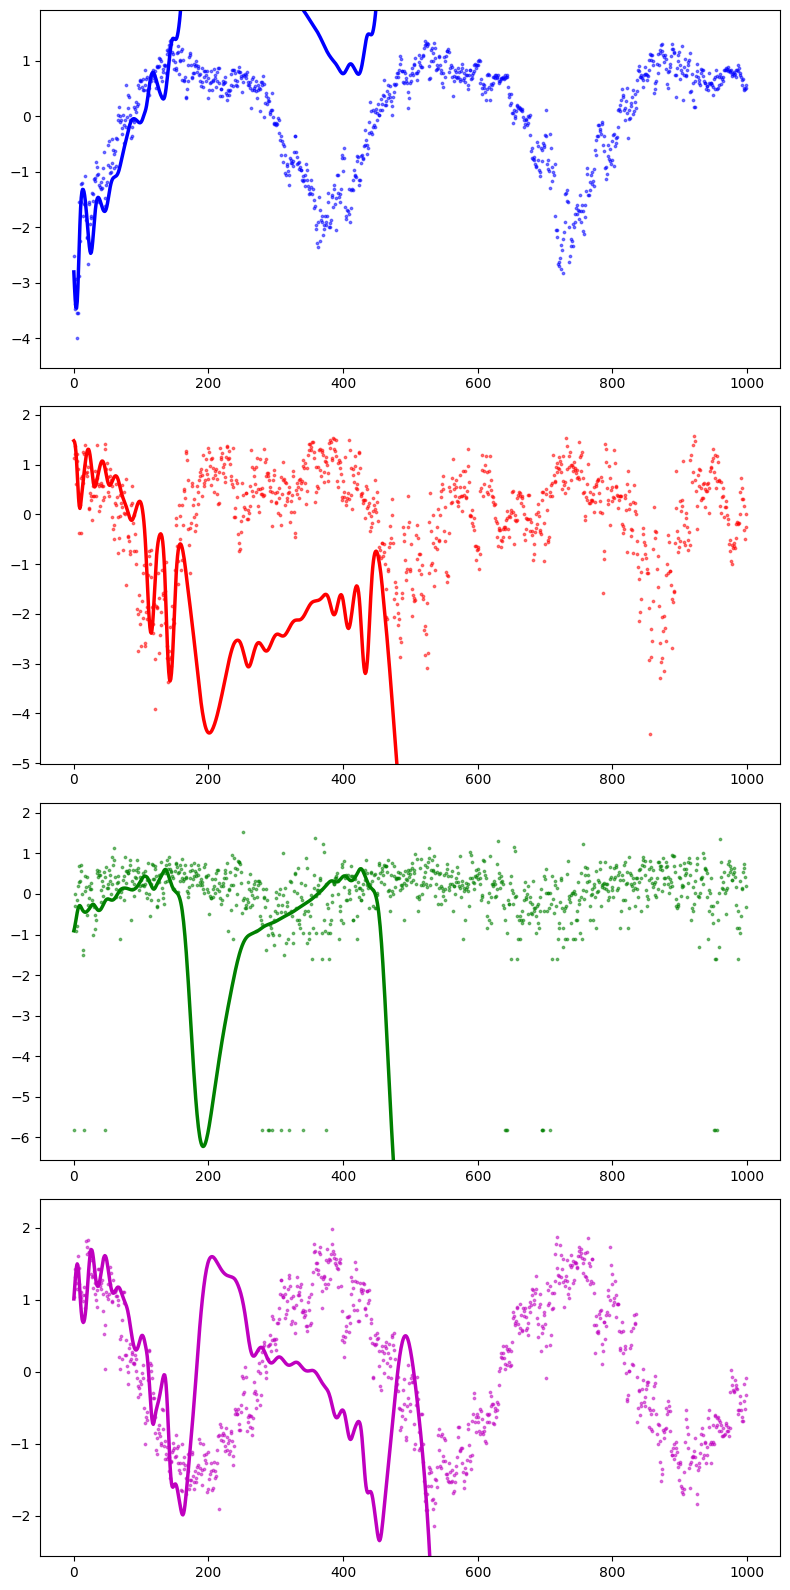

In [60]:
# reconstruction 
trecon = tdata
x0 = xinfer[0,:].squeeze() # inferred initial state
tr, xr = model.predict(trecon[1:],trecon[:1],x0,random=False) # reconstructed trajectory
# visualization
col = ['b','r','g','m','y']
fig = plt.figure(figsize=(8,16), facecolor='w')
for i in range(no_comp):
    ax = fig.add_subplot(no_comp, 1, (i+1))
    ax.plot(tr, xr[:,i], color=col[i], lw=2.5)
    ax.scatter(tdata, xdata[:,i], s=3, marker='o', color=col[i], alpha=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(np.min(xdata[:,i])-0.1*np.ptp(xdata[:,i]),np.max(xdata[:,i])+0.1*np.ptp(xdata[:,i]))
fig.tight_layout()
plt.show()